# GAN - Create Probabilistic Distribution
- Fully connected  layer GAN

![GAN](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11000153/g1.jpg)

In [1]:
%matplotlib inline
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

/Users/skim0119/venv/GenP3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/skim0119/venv/GenP3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare Data

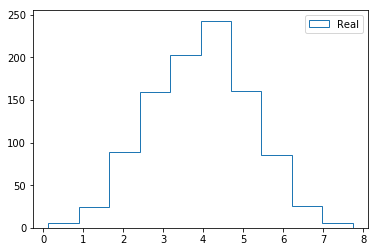

In [2]:
data_mean = 4
data_stddev = 1.25
ni_D=100

real_sample = lambda n_batch: np.random.normal(data_mean, data_stddev, (n_batch, ni_D))
in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)

plt.hist(real_sample(10).reshape(-1), histtype='step', label='Real')
plt.legend(loc=0)
plt.show()

## Model

In [3]:
adam = Adam(lr=0.0002, beta_1=0.9, beta_2=0.999)
def set_compile(model):
    return model.compile(loss='binary_crossentropy',
                         optimizer=Adam(lr=0.0002, beta_1=0.9, beta_2=0.999),
                         metrics=['accuracy'])

# set dimension
disc_inp = 100
disc_hid = 50
gene_hid = 50

In [4]:
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

### Generator Network

In [5]:
gen_model = Sequential()  # (Batch, disc_inp)
gen_model.add(Reshape((disc_inp, 1), input_shape=(disc_inp,)))  # (Batch, steps=disc_inp, input_dim=1)
gen_model.add(Conv1D(gene_hid, 1, activation='relu'))  # (Batch, disc_inp, gene_hid)
gen_model.add(Conv1D(gene_hid, 1, activation='sigmoid'))  # (Batch, disc_inp, gene_hid)
gen_model.add(Conv1D(1, 1))  # (Batch, disc_inp, 1)
gen_model.add(Flatten())  # (Batch, disc_inp)

set_compile(gen_model)

### Discriminator Network

In [6]:
dis_model = Sequential()
dis_model.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(disc_inp,)))
dis_model.add(Dense(disc_hid, activation='relu'))
dis_model.add(Dense(disc_hid, activation='relu'))
dis_model.add(Dense(1, activation='sigmoid'))

set_compile(dis_model)

### Generator + Discriminator Network

In [7]:
total_model = Sequential()
total_model.add(gen_model)
total_model.add(dis_model)
dis_model.trainable = False
set_compile(total_model)
dis_model.trainable = True

## Training

In [8]:
def discriminator_train_on_batch(Real, Gen):
    X = np.concatenate([Real, Gen], axis=0)
    y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
    dis_model.train_on_batch(X, y)

def total_train_on_batch(Z):
    y = np.array([1] * Z.shape[0])
    total_model.train_on_batch(Z, y)

In [9]:
n_batch = 1
n_iter_D = 1
n_iter_G = 5

def train(epochs):
    for epoch in range(epochs):
        # Train Discriminator
        for i in range(n_iter_D):
            r = real_sample(n_batch)
            z = in_sample(n_batch)  # input sample
            predict = gen_model.predict(z)

            dis_model.trainable = True
            discriminator_train_on_batch(r, predict)
            
        # Train Generator after
        for i in range(n_iter_G):
            z = in_sample(n_batch)
            dis_model.trainable = False
            total_train_on_batch(z)

def visualize(n_test):
    z = in_sample(n_test)
    predict = gen_model.predict(z)
    r = real_sample(n_test)
    
    plt.hist(r.reshape(-1), histtype='step', label='Real')
    plt.hist(predict.reshape(-1), histtype='step', label='Generated')
    plt.legend(loc=0)
    plt.show()
    
    def stat(d):
        return (np.mean(d), np.std(d))
    print('Mean and Std of Real:', stat(r))
    print('Mean and Std of Gen:', stat(predict))

Stage 0 (Epoch: 0)


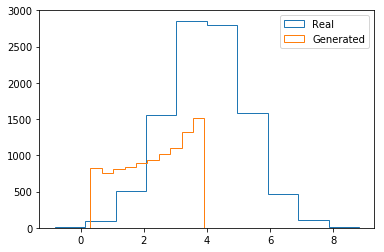

Mean and Std of Real: (3.9912300750455847, 1.2440979858801862)
Mean and Std of Gen: (2.3360398, 1.0654552)
Stage 1 (Epoch: 200)
Stage 2 (Epoch: 400)
Stage 3 (Epoch: 600)
Stage 4 (Epoch: 800)
Stage 5 (Epoch: 1000)
Stage 6 (Epoch: 1200)
Stage 7 (Epoch: 1400)
Stage 8 (Epoch: 1600)
Stage 9 (Epoch: 1800)
Stage 10 (Epoch: 2000)
Stage 11 (Epoch: 2200)
Stage 12 (Epoch: 2400)
Stage 13 (Epoch: 2600)
Stage 14 (Epoch: 2800)
Stage 15 (Epoch: 3000)
Stage 16 (Epoch: 3200)
Stage 17 (Epoch: 3400)
Stage 18 (Epoch: 3600)
Stage 19 (Epoch: 3800)
Stage 20 (Epoch: 4000)


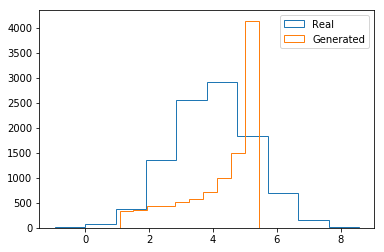

Mean and Std of Real: (3.99683352269331, 1.2526851290487206)
Mean and Std of Gen: (4.2911634, 1.1995435)
Stage 21 (Epoch: 4200)
Stage 22 (Epoch: 4400)
Stage 23 (Epoch: 4600)
Stage 24 (Epoch: 4800)
Stage 25 (Epoch: 5000)
Stage 26 (Epoch: 5200)
Stage 27 (Epoch: 5400)
Stage 28 (Epoch: 5600)
Stage 29 (Epoch: 5800)
Stage 30 (Epoch: 6000)
Stage 31 (Epoch: 6200)
Stage 32 (Epoch: 6400)
Stage 33 (Epoch: 6600)
Stage 34 (Epoch: 6800)
Stage 35 (Epoch: 7000)
Stage 36 (Epoch: 7200)
Stage 37 (Epoch: 7400)
Stage 38 (Epoch: 7600)
Stage 39 (Epoch: 7800)
Stage 40 (Epoch: 8000)


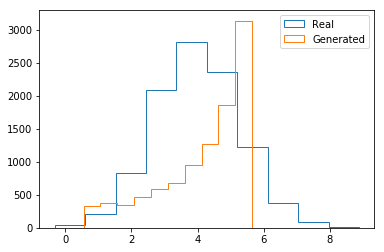

Mean and Std of Real: (3.9790354069486247, 1.258880710088651)
Mean and Std of Gen: (4.1840825, 1.342665)
Stage 41 (Epoch: 8200)
Stage 42 (Epoch: 8400)
Stage 43 (Epoch: 8600)
Stage 44 (Epoch: 8800)
Stage 45 (Epoch: 9000)
Stage 46 (Epoch: 9200)
Stage 47 (Epoch: 9400)
Stage 48 (Epoch: 9600)
Stage 49 (Epoch: 9800)
Stage 50 (Epoch: 10000)
Stage 51 (Epoch: 10200)
Stage 52 (Epoch: 10400)
Stage 53 (Epoch: 10600)
Stage 54 (Epoch: 10800)
Stage 55 (Epoch: 11000)
Stage 56 (Epoch: 11200)
Stage 57 (Epoch: 11400)
Stage 58 (Epoch: 11600)
Stage 59 (Epoch: 11800)
Stage 60 (Epoch: 12000)


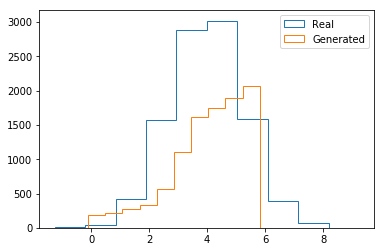

Mean and Std of Real: (4.001496862704738, 1.2578327625786403)
Mean and Std of Gen: (4.0618825, 1.3058584)
Stage 61 (Epoch: 12200)
Stage 62 (Epoch: 12400)
Stage 63 (Epoch: 12600)
Stage 64 (Epoch: 12800)
Stage 65 (Epoch: 13000)
Stage 66 (Epoch: 13200)
Stage 67 (Epoch: 13400)
Stage 68 (Epoch: 13600)
Stage 69 (Epoch: 13800)
Stage 70 (Epoch: 14000)
Stage 71 (Epoch: 14200)
Stage 72 (Epoch: 14400)
Stage 73 (Epoch: 14600)
Stage 74 (Epoch: 14800)
Stage 75 (Epoch: 15000)
Stage 76 (Epoch: 15200)
Stage 77 (Epoch: 15400)
Stage 78 (Epoch: 15600)
Stage 79 (Epoch: 15800)
Stage 80 (Epoch: 16000)


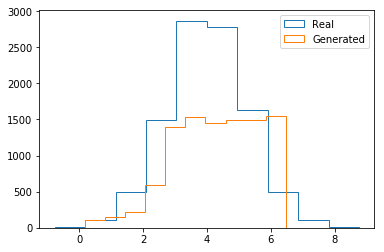

Mean and Std of Real: (4.015611104466237, 1.2416844168754602)
Mean and Std of Gen: (4.321155, 1.3399917)
Stage 81 (Epoch: 16200)
Stage 82 (Epoch: 16400)
Stage 83 (Epoch: 16600)
Stage 84 (Epoch: 16800)
Stage 85 (Epoch: 17000)
Stage 86 (Epoch: 17200)
Stage 87 (Epoch: 17400)
Stage 88 (Epoch: 17600)
Stage 89 (Epoch: 17800)
Stage 90 (Epoch: 18000)
Stage 91 (Epoch: 18200)
Stage 92 (Epoch: 18400)
Stage 93 (Epoch: 18600)
Stage 94 (Epoch: 18800)
Stage 95 (Epoch: 19000)
Stage 96 (Epoch: 19200)
Stage 97 (Epoch: 19400)
Stage 98 (Epoch: 19600)
Stage 99 (Epoch: 19800)
Stage 100 (Epoch: 20000)


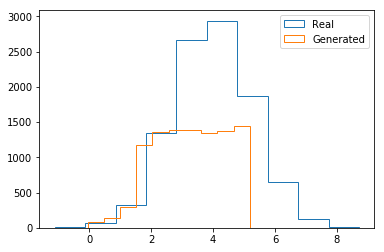

Mean and Std of Real: (3.9962039084296643, 1.2554637123398271)
Mean and Std of Gen: (3.2708561, 1.1550837)
Stage 101 (Epoch: 20200)
Stage 102 (Epoch: 20400)
Stage 103 (Epoch: 20600)
Stage 104 (Epoch: 20800)
Stage 105 (Epoch: 21000)
Stage 106 (Epoch: 21200)
Stage 107 (Epoch: 21400)
Stage 108 (Epoch: 21600)
Stage 109 (Epoch: 21800)
Stage 110 (Epoch: 22000)
Stage 111 (Epoch: 22200)
Stage 112 (Epoch: 22400)
Stage 113 (Epoch: 22600)
Stage 114 (Epoch: 22800)
Stage 115 (Epoch: 23000)
Stage 116 (Epoch: 23200)
Stage 117 (Epoch: 23400)
Stage 118 (Epoch: 23600)
Stage 119 (Epoch: 23800)
Stage 120 (Epoch: 24000)


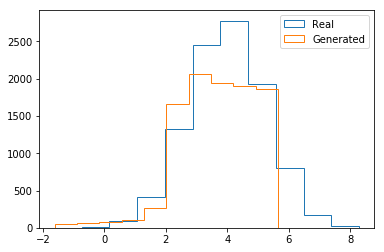

Mean and Std of Real: (3.9929876090075465, 1.2409500881337914)
Mean and Std of Gen: (3.690912, 1.228524)
Stage 121 (Epoch: 24200)
Stage 122 (Epoch: 24400)
Stage 123 (Epoch: 24600)
Stage 124 (Epoch: 24800)
Stage 125 (Epoch: 25000)
Stage 126 (Epoch: 25200)
Stage 127 (Epoch: 25400)
Stage 128 (Epoch: 25600)
Stage 129 (Epoch: 25800)
Stage 130 (Epoch: 26000)
Stage 131 (Epoch: 26200)
Stage 132 (Epoch: 26400)
Stage 133 (Epoch: 26600)
Stage 134 (Epoch: 26800)
Stage 135 (Epoch: 27000)
Stage 136 (Epoch: 27200)
Stage 137 (Epoch: 27400)
Stage 138 (Epoch: 27600)
Stage 139 (Epoch: 27800)
Stage 140 (Epoch: 28000)


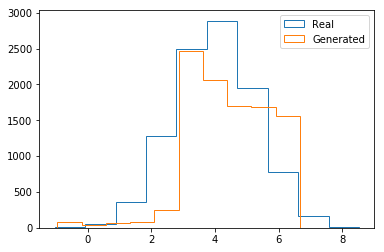

Mean and Std of Real: (4.0065048222684245, 1.2570213791532112)
Mean and Std of Gen: (4.4274263, 1.2913477)
Stage 141 (Epoch: 28200)
Stage 142 (Epoch: 28400)
Stage 143 (Epoch: 28600)
Stage 144 (Epoch: 28800)
Stage 145 (Epoch: 29000)
Stage 146 (Epoch: 29200)
Stage 147 (Epoch: 29400)
Stage 148 (Epoch: 29600)
Stage 149 (Epoch: 29800)
Stage 150 (Epoch: 30000)
Stage 151 (Epoch: 30200)
Stage 152 (Epoch: 30400)
Stage 153 (Epoch: 30600)
Stage 154 (Epoch: 30800)
Stage 155 (Epoch: 31000)
Stage 156 (Epoch: 31200)
Stage 157 (Epoch: 31400)
Stage 158 (Epoch: 31600)
Stage 159 (Epoch: 31800)
Stage 160 (Epoch: 32000)


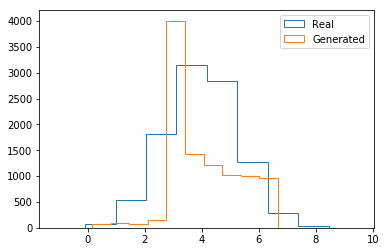

Mean and Std of Real: (3.9910535235287723, 1.2527586783463418)
Mean and Std of Gen: (4.024385, 1.2668993)
Stage 161 (Epoch: 32200)
Stage 162 (Epoch: 32400)
Stage 163 (Epoch: 32600)
Stage 164 (Epoch: 32800)
Stage 165 (Epoch: 33000)
Stage 166 (Epoch: 33200)
Stage 167 (Epoch: 33400)
Stage 168 (Epoch: 33600)
Stage 169 (Epoch: 33800)
Stage 170 (Epoch: 34000)
Stage 171 (Epoch: 34200)
Stage 172 (Epoch: 34400)
Stage 173 (Epoch: 34600)
Stage 174 (Epoch: 34800)
Stage 175 (Epoch: 35000)
Stage 176 (Epoch: 35200)
Stage 177 (Epoch: 35400)
Stage 178 (Epoch: 35600)
Stage 179 (Epoch: 35800)
Stage 180 (Epoch: 36000)


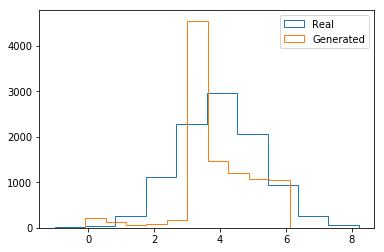

Mean and Std of Real: (4.006665777846503, 1.2486993085239984)
Mean and Std of Gen: (3.8191605, 1.1719447)
Stage 181 (Epoch: 36200)
Stage 182 (Epoch: 36400)
Stage 183 (Epoch: 36600)
Stage 184 (Epoch: 36800)
Stage 185 (Epoch: 37000)
Stage 186 (Epoch: 37200)
Stage 187 (Epoch: 37400)
Stage 188 (Epoch: 37600)
Stage 189 (Epoch: 37800)
Stage 190 (Epoch: 38000)
Stage 191 (Epoch: 38200)
Stage 192 (Epoch: 38400)
Stage 193 (Epoch: 38600)
Stage 194 (Epoch: 38800)
Stage 195 (Epoch: 39000)
Stage 196 (Epoch: 39200)
Stage 197 (Epoch: 39400)
Stage 198 (Epoch: 39600)
Stage 199 (Epoch: 39800)


In [10]:
n_repeat=200
n_show=200
n_test=100
for i in range(n_repeat):
    print('Stage', i, '(Epoch: {})'.format(i * n_show))

    train(n_show)
    if i % 20 == 0: visualize(n_test)

    plt.show()